###The prostate cancer data

The variables in the data are as follows: 

- `lcavol`: log cancer volume (dependent variable)
- `lweight`: log prostate weight volumne
- `age`: age
- `lbph`: log benign prostatic hyperplasia
- `svi`: seminal vesicle invasion
- `lcp`: log capsular penetration
- `gleason`: Gleason score
- `pgg45`: percent Gleason scores 4 or 5
- `lpsa`: log prostate specific antigen

####Load modules and the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import seaborn as sns 
from sklearn.cross_validation import LeaveOneOut, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

cancer = pd.read_csv('Prostate.csv')
cancer.drop('train', axis=1, inplace=True)  # drop train column

y = cancer.pop('lcavol').values
X = StandardScaler().fit_transform(cancer)

####If we are only interested in prediction performance in LOOCV

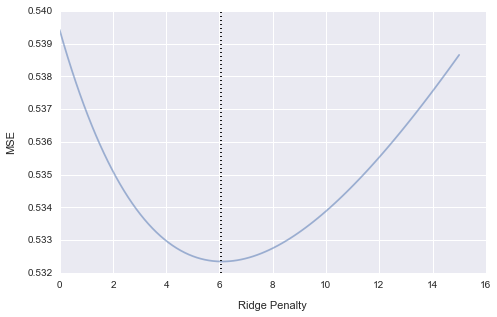

In [2]:
coefs = []
scores = []
alphas = np.linspace(0, 15, 100)

for alpha in alphas:     
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    coefs.append(model.coef_)
    scores.append(cross_val_score(model, X, y, 
                                  scoring='mean_squared_error', 
                                  cv=LeaveOneOut(n=X.shape[0]), 
                                  n_jobs=-1)
                  .mean() * -1)

plt.figure(figsize=(7, 4.5))
plt.plot(alphas, scores, alpha=0.5)
plt.xlabel('Ridge Penalty', labelpad=11); plt.ylabel('MSE', labelpad=11)
plt.axvline(x=alphas[np.argmin(scores)], color='k', linestyle=':')
plt.tight_layout(); 

####Class for the jackknife

If, however, we also want the coefficient estimates for the jackknife method, we can set up a little class to evaluate this alongside the LOOCV performance for given hyperparameters. 

In [3]:
class JackKnifeRegression(object): 
    
    def __init__(self, X, y): 
        self.X = X
        self.y = y
        self.N = self.X.shape[0]
    
    def fit(self, alpha): 
        self.model = Ridge(alpha=alpha)
        
        coefs = []
        error = []
        for train, test in LeaveOneOut(self.N): 
            X_train, y_train = self.X[train], self.y[train]
            X_test, y_test = self.X[test], self.y[test]
            
            self.model.fit(X_train, y_train)
            coefs.append(self.model.coef_)
        
            yhat = self.model.predict(X_test)
            error.append(y_test - yhat)
            
        self.coefs = np.vstack(coefs).mean(axis=0)
        self.mse = (np.array(error) ** 2).mean() 

####Evaluate the estimates and the performance across ridge penalty values 

In [4]:
jack = JackKnifeRegression(X, y)

alphas = np.linspace(0, 15, 100)
coefs, mses = [], []
for a in alphas:
    jack.fit(alpha=a)
    coefs.append(jack.coefs)
    mses.append(jack.mse)
    
optimal_alpha = alphas[np.argmin(mses)]

####Plot the performance and the coefficient paths

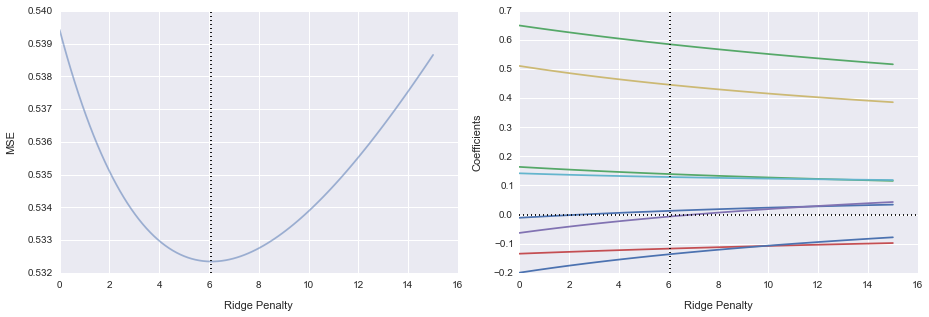

In [5]:
plt.figure(figsize=(13, 4.5))

plt.subplot(121)
plt.plot(alphas, mses, linestyle='-', alpha=0.5)
plt.xlabel('Ridge Penalty', labelpad=11); plt.ylabel('MSE', labelpad=11)
plt.axvline(x=optimal_alpha, color='k', linestyle=':')

plt.subplot(122)
plt.plot(alphas, np.vstack(coefs))
plt.xlabel('Ridge Penalty', labelpad=11); plt.ylabel('Coefficients', labelpad=11)
plt.axhline(y=0, color='k', linestyle=':')
plt.axvline(x=optimal_alpha, color='k', linestyle=':')

plt.tight_layout(); 

####Show the estimates for the optimal level of penalization

In [6]:
estimates = coefs[np.argmin(mses)]
print pd.Series(estimates, index=cancer.columns.values)

lweight    0.012828
age        0.139096
lbph      -0.116968
svi       -0.006615
lcp        0.445951
gleason    0.128919
pgg45     -0.136131
lpsa       0.585025
dtype: float64
